![title](QMlogo.png)

|MTH786U/P, Semester C, 2020/2021||
|:--|--:|
|Assignment 5 Solutions|M. Poplavskyi|


In the following $2$ exercises you will be asked to implement $K$-fold cross-validation 
	and the gradient descent methods on a given data. The assignment folder contains
	a helper file (external module)	called \texttt{MLHelper.py}. You can import it and
	use any function from it by calling

In [86]:
import MLHelper as ml

In [87]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Standardisation and de-standardisation  of the data

The goal of applying $\textit{standardisation}$ is to make sure different features of objects are on 
	almost the same scale so that each feature is equally important and make it easier to process by 
	most ML algorithms. The result of standardisation is that the features will be rescaled to ensure 
	the mean and the standard deviation to be $0$ and $1$, respectively. This means that for a data
	given by $\mathbf{x} = \left(x_1,x_2,\ldots,x_n\right) \in \mathbb{R}^n$ we define a new, rescaled data as:
	\begin{equation*}
		\hat x_i = \frac{x_i - \left\langle \mathbf{x} \right\rangle }{\sigma_{\mathbf{x}}},
	\end{equation*}
	where $\left\langle \mathbf{x} \right\rangle = \frac{1}{n}\sum\limits_{j=1}^n x_j$, and
	$\sigma_\mathbf{x} = \sqrt{
	\frac{1}{n}\sum\limits_{j=1}^n \left(x_j-\left\langle \mathbf{x} \right\rangle\right)^2}$
	are the mean and standard deviation of $\mathbf{x}$.  
- $\label{itm:standardise}$ Write two functions $\texttt{standardise}$ and $\texttt{de_standardise}$ to (de-)standardise the columns of a multi-dimensional array. The function $\texttt{standardise}$	takes the multi-dimensional array $\texttt{matrix}$ as its input argument. It subtracts the means from each column and divides by the standard deviations. It returns the standardised matrix, the row of means and the row of standard deviations. The function $\texttt{de_standardise}$ reverses this operation. It takes a standardised matrix, the row of means and the row of standard deviations as its arguments and returns a matrix for which the standardisation process is reversed.

In [88]:
def standardise(matrix):
    row_of_means = np.mean(matrix, axis=0)
    standardised_matrix = matrix - row_of_means
    row_of_stds = np.std(standardised_matrix, axis=0)
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds


def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means

### Model selection: cross validation

In this exercise you will work with a real housing price data. The assignment folder contains $\texttt{house\_prices.csv}$ file which you will need to read the data from. This file contains the information about $N = 1200$ houses. The data columns are:
- $\texttt{StreetLength}$ - length of the street in front of the building
- $\texttt{Area}$ - total area of the lot
- $\texttt{Quality}$ - quality of building materials
- $\texttt{Condition}$ - condition of the building
- $\texttt{BasementArea}$ - area of the basement
- $\texttt{LivingArea}$ - total living area
- $\texttt{GarageArea}$ - a garage area		
- $\texttt{SalePrice}$ - sale price

Your task would be to build a ridge regression using $K$-fold cross validation strategy for validation and a grid search strategy for optimisation over hyperparameter $\alpha$.

1. $\label{housing:data}$ Download the information of numerous houses from the $\texttt{houses_prices.csv}$ dataset. In order to do so, download $\texttt{MLHelper.py}$ from the QM+ module page and import the $\texttt{load_housing_data}$ function from the module $\texttt{MLHelper}$. Use this function to load the data via the command $\texttt{housing_data, housing_prices = load_housing_data()}$. Standardise the data using the function $\texttt{standrdise}$ you have written before.

In [89]:
housing_data, housing_prices = ml.load_housing_data()
standardised_housing_data, means_housing_data, stds_housing_data = standardise(
    housing_data)
standardised_housing_prices, means_housing_prices, stds_housing_prices = standardise(
    housing_prices)

2. $\label{housing:ridge}$ Use a function $\texttt{ridge_regression}$ available from the module $\texttt{MLHelper}$ that takes three arguments $\texttt{data_x}$, $\texttt{data_y}$,and	$\texttt{alpha}$, which computes and returns the solution $w_{\alpha}$ of the normal equation
$$
\left(X^{\top} X + \alpha I\right)w_{\alpha} = X^{\top}y.
$$
Here $X$ is the mathematical representation of $\texttt{data_x}$ and $y$ is the mathematical representation of $\texttt{data_y}$.

In [90]:
w = ml.ridge_regression(standardised_housing_data, standardised_housing_prices,
                        0)
print(w)

[-0.00997711  0.06980294  0.46026402  0.03218984  0.14526004  0.26548819
  0.15698474]


3. $\label{housing:validation}$ Define a 		$\href{https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions}{lambda function}$ $\texttt{linear_regression}$ that takes two arguments $\texttt{w}$ and $\texttt{x}$ and evaluates $f_{w}\left(x\right)$. Define another $\href{https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions}{lambda function}$ $\texttt{error_measure}$ that takes two numeric arguments $\texttt{f}$ and $\texttt{y}$ and evaluates	$\frac{1}{2}\left(f-y\right)^2$. Finally, implement a function $\texttt{validation_error}$ that takes $3$ parameters: $\texttt{validation_x}$, $\texttt{validation_y}$, $\texttt{w}$ and evaluates	the validation error
$$
\begin{align*}
\text{Val}_{S_v}(w) = \frac{1}{2|S_v|} 
\sum_{(x_i, y_i) \in S_v} | f_{w}(x_i) - y_i |^2 \, ,
\end{align*}
$$
between output samples $\{ y_i^v \}_{i = 1}^{|S_v|}$ (represented by $\texttt{validation_y}$) from a validation data set $S_v$ and the outputs of the ridge regression function $f_w$ for matching inputs $\{ x_i^v \}_{i = 1}^{|S_v|}$ (represented by $\texttt{validation_x}$) from $S_v$.

In [91]:
linear_regression = lambda x, w: x @ w.T
error_measure = lambda f, y: (f - y)**2 / 2


def validation_error(data_x, data_y, w):
    error = 0
    s = data_x.shape[0]
    for i in range(s):
        error += error_measure(linear_regression(data_x[i, :], w),
                               data_y[i]) / s
    return error

4. Implement a $K$-fold cross validation strategy as introduced in the lectures. Write a function $\texttt{data_split}$ that takes arguments $\texttt{data}$ and $\texttt{K}$ and splits the data randomly into $K$ equal (or almost equal) chunks. Write a function $\texttt{KFold_validation_error}$ that takes arguments $\texttt{data_x}$, $\texttt{data_y}$, $\texttt{alpha}$, $\texttt{K}$, and 
    - using the function $\texttt{data_split}$, splits the data into $K$ chunks;
	- uses $K-1$ sets to compute the ridge regression weights $w_{\alpha}$ and the remaining set as the validation set $S_v$ for the calculation of an error; 
	- repeats this for all combinations, and average your results;
	- returns the average regression coefficients $\left\langle w_{\alpha}\right\rangle$ and the corresponding validation error $\left\langle \mathrm{Val}_{S_v}\left( w_{\alpha}\right)\right\rangle$.

In [92]:
def data_split(data, K):
    no_samples = data.shape[0]
    indices = np.random.permutation(no_samples)

    m, r = divmod(no_samples, K)
    indices_split = [
        indices[i * m + min(i, r):(i + 1) * m + min(i, r)] for i in range(K)
    ]

    return [data[indices_split[i]] for i in range(K)]


def KFold_validation_error(data_x, data_y, alpha, K):
    data_xy = np.c_[data_x, data_y]
    data_chunks = data_split(data_xy, K)

    average_w = np.zeros(data_x.shape[1])
    average_error = 0
    for i in range(K):
        training_data = np.concatenate(
            [data_chunks[j] for j in range(K) if (j != i)], axis=0)
        validation_data = data_chunks[i]
        w = ml.ridge_regression(training_data[:, :-1],
                                         training_data[:, -1], alpha)
        average_error += validation_error(validation_data[:, :-1],
                                         validation_data[:, -1], w) / K
        average_w +=w/K

    return average_w, average_error

5. Implement a grid search algorithm to find an unknown parameter $\hat \alpha$ such that
$$
\hat{\alpha} = \arg\min\limits_{\alpha\geq 0} \left\langle \mathrm{Val}_{S_v}\left( w_{\alpha}\right)\right\rangle.
$$

An optimal regularisation parameter is 15


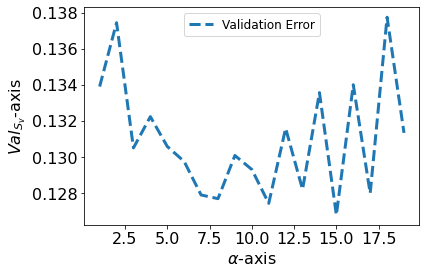

In [93]:
K_global = 5
def grid_search(grid):
    function_values = []
    for point in grid:
        _, error = KFold_validation_error(standardised_housing_data, standardised_housing_prices, point, K_global)
        function_values.append(error)
    
    plt.plot(grid, function_values, '--', linewidth=3, label='Validation Error')
    plt.legend( prop={'size': 12})
    plt.xlabel(r'$\alpha$-axis', fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel(r'$Val_{S_v}$-axis', fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout;    
    return grid[np.argmin(function_values)], np.min(function_values)

optimal_alpha, _ = grid_search(np.arange(1,20,1))
print("An optimal regularisation parameter is {}".format(optimal_alpha))

## Gradient descent

The goal of this exercise is to minimise the mean squared error via gradient descent. Please follow the following steps.
	
1. $\label{itm:data}$ Download and visualise the height- and weight-information of numerous individuals from the $\texttt{height-weight-genders.csv}$ dataset. In order to do so, import the $\texttt{load_measurements_data}$ function from the file $\texttt{MLHelper.py}$. Use this function to load the data via the command $\texttt{height, weight, _ = load_measurements_data()}$. Sort the data points in terms of their height for later visualisations. Visualise the data points with your favourite tools from the Matplotlib library.

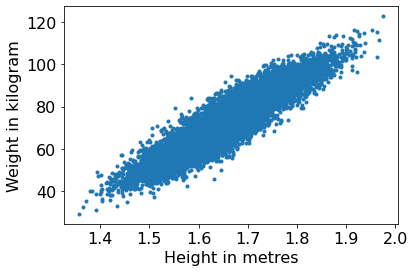

In [94]:
height, weight, _ = ml.𝚕𝚘𝚊𝚍_𝚖𝚎𝚊𝚜𝚞𝚛𝚎𝚖𝚎𝚗𝚝𝚜_𝚍𝚊𝚝𝚊()
indices = np.argsort(height)
height = height[indices]
weight = weight[indices]
plt.plot(height, weight, '.', linewidth=3)
plt.xlabel('Height in metres', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Weight in kilogram', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout;

		
2. $\label{itm:regression}$ Standardise the height and weight arrays from Question \eqref{itm:data}. Use the standardised height array to create a polynomial basis matrix of degree one. You can use your methods from the previous coursework, or use the functions provided in the file $\texttt{MLHelper.py}$. Compute the optimal weights by performing linear regression as you did in the previous coursework. A function $\texttt{regression}$ is also provided with the file $\texttt{MLHelper.py}$.

In [95]:
def polynomial_basis(inputs, degree=1):
    basis_matrix = np.ones((len(inputs), 1))
    for counter in range(1, degree + 1):
        basis_matrix = np.c_[basis_matrix, np.power(inputs, counter)]
    return basis_matrix
def polynomial_regression(basis_matrix, outputs):
    gram_matrix = basis_matrix.T @ basis_matrix
    right_hand_side = basis_matrix.T @ outputs.reshape(-1, 1)
    return np.linalg.solve(gram_matrix, right_hand_side)

height_standardised, _, _ = standardise(height.reshape(-1, 1))
data_matrix = polynomial_basis(height_standardised, 1)
data_samples, row_of_means, row_of_stds = standardise(weight.reshape(-1, 1))

optimal_weights = polynomial_regression(data_matrix, data_samples)
print("The optimal weights for MSE regression with a linear model are {w}.T.".format( \
            w=optimal_weights.T))

The optimal weights for MSE regression with a linear model are [[2.27524330e-16 9.24756299e-01]].T.


		
3. Visualise your results from Question $\eqref{itm:regression}$. Apply the forward model to your optimal weights and use the $\texttt{de_standardise}$ function from Question \eqref{itm:standardise}. Plot your results together with the data points.

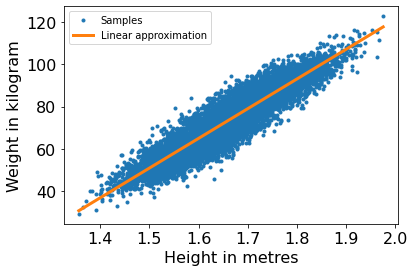

In [96]:
model_output = de_standardise(data_matrix @ optimal_weights, row_of_means, row_of_stds)
plt.plot(height, weight, '.', linewidth=3, label='Samples')
plt.plot(height, model_output, linewidth=3, label='Linear approximation')
plt.xlabel('Height in metres', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Weight in kilogram', fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.tight_layout;

		
4. $\label{itm:mse}$ Write two functions $\texttt{mean_squared_error}$ and $\texttt{mean_squared_error_gradient}$ that implement the mean squared error	and its gradient as defined in the lecture notes. Both functions take a two-dimensional NumPy array $\texttt{data_matrix}$, a one-dimensional NumPy array $\texttt{weights}$ and a one-dimensional NumPy array $\texttt{outputs}$ as arguments

In [97]:
def mean_squared_error(data_matrix, weights, outputs):
    return np.mean((data_matrix @ weights - outputs) ** 2) / 2

def mean_squared_error_gradient(data_matrix, weights, outputs):
    return (data_matrix.T @ (data_matrix @ weights - outputs)) / len(outputs)

We compute the value *optimal_mean_squared_error* of the mean-squared-error for the optimal weights *optimal_weights* that we have computed earlier.

In [98]:
optimal_mean_squared_error = mean_squared_error(data_matrix, optimal_weights, data_samples)
print("The optimal mean squared error is {mse}.".format(mse=optimal_mean_squared_error))

The optimal mean squared error is 0.07241289396950212.


5. $\label{itm:gd}$ Implement a function $\texttt{gradient_descent}$ that performs gradient descent to numerically approximate a minimiser of a convex function $\texttt{objective}$ with gradient $\texttt{gradient}$. In addition to the functions $\texttt{objective}$ and $\texttt{gradient}$ that take a NumPy array as their argument, the arguments for this function are a NumPy array $\texttt{initial_weights}$ with initial values for the first iterate, a step-size parameter $\texttt{step_size}$ for the gradient descent step and a parameter $\texttt{no_of_iterations}$ that controls the number of iterations. Implement the function so that it returns a NumPy array of the weights obtained after gradient descent together with a list of objective values for all iterates.	

In [99]:
def gradient_descent(objective, gradient, initial_weights, step_size=1, \
                     no_of_iterations=100, print_output=10):
    objective_values = []
    weights = np.copy(initial_weights)
    objective_values.append(objective(weights))
    for counter in range(no_of_iterations):
        weights -= step_size * gradient(weights)
        objective_values.append(objective(weights))
        if (counter + 1) % print_output == 0:
            print("Iteration {k}/{m}, objective = {o}.".format(k=counter+1, \
                    m=no_of_iterations, o=objective_values[counter]))
    print("Iteration completed after {k}/{m}, objective = {o}.".format(k=counter + 1, \
                m=no_of_iterations, o=objective_values[counter]))
    return weights, objective_values

6. Use the function $\texttt{gradient_descent}$ from Question \eqref{itm:gd} to minimise the mean squared error (and thus, to compute a solution to the linear regression problem). Experiment with different initialisations and parameters. How should the step-size parameter be chosen? Compare your result to the reference-solution from Question $\eqref{itm:regression}$.$\textbf{Hint}$: make use of your functions from Question $\eqref{itm:mse}$ and Python's 		$\href{https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions}{lambda function}$.
	

We make use of *mean_squared_error*, *mean_squared_error_gradient* and Python's **lambda**-function to set up the arguments *objective* and *gradient*.

In [100]:
objective = lambda weights: mean_squared_error(data_matrix, weights, data_samples)
gradient = lambda weights: mean_squared_error_gradient(data_matrix, weights, data_samples)

We use the function **gradient_descent** to minimise the mean squared error (and thus, to compute a solution *gradient_descent_weights* to the linear regression problem) with zeros as initial weights.

In [101]:
initial_weights = np.zeros((data_matrix.shape[1], 1))
no_of_iterations=100
step_size = (1.9 * len(data_samples))/(np.linalg.norm(data_matrix, 2) ** 2)
gradient_descent_weights, objective_values = gradient_descent(objective, gradient, \
                                    initial_weights, step_size, no_of_iterations, 10)

Iteration 10/100, objective = 0.1365914247068438.
Iteration 20/100, objective = 0.08021550503308562.
Iteration 30/100, objective = 0.07336150931968392.
Iteration 40/100, objective = 0.07252822345027048.
Iteration 50/100, objective = 0.07242691534194962.
Iteration 60/100, objective = 0.07241459864105705.
Iteration 70/100, objective = 0.07241310121776695.
Iteration 80/100, objective = 0.07241291916605283.
Iteration 90/100, objective = 0.07241289703281446.
Iteration 100/100, objective = 0.07241289434192938.
Iteration completed after 100/100, objective = 0.07241289434192938.


In [102]:
print("The weights obtained with gradient descent after {it} iterations".format( \
        it=no_of_iterations),"\nand step-size {s} are {w}.T".format(s=step_size, \
        w= gradient_descent_weights.T))

The weights obtained with gradient descent after 100 iterations 
and step-size 1.8999999999999972 are [[5.24487120e-16 9.24731736e-01]].T
